# 타이타닉 생존자 예측(Titanic Passengers Survival) with XGBoost & Grid Search

In [75]:
import pandas as pd
import numpy as np

from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

from xgboost import XGBClassifier
from xgboost import plot_importance

import matplotlib.pyplot as plt
import seaborn as sns

## 데이터 불러오기

In [76]:
train_df = pd.read_csv("../data/titanic_train.csv")
test_df  = pd.read_csv("../data/titanic_test.csv")
# (len(train_df), len(test_df))

In [77]:
# 두개를 붙이는데 행을 기준으로 붙이고 인덱스를 무시, 정렬한다.
# 데이터가 많은 걸 먼저 놓고 작은걸 뒤로 붙여야함
titanic_df = pd.concat([train_df, test_df], axis=0 , ignore_index=True, sort=True)

titanic_df.info()
# train_df.info()
# test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1046 non-null   float64
 1   Cabin        295 non-null    object 
 2   Embarked     1307 non-null   object 
 3   Fare         1308 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   object 
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Ticket       1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


* 데이터 종류

Variable Name | Description
------------------|-------------
PassengerId | Passenger Id (unique) =====> 승객 번호
Survived | Survived (1) or died (0) =====> 승객 생존 여부
Pclass | Passenger's class (1/Upper, 2/Middle, 3/Lower) =====> 선실등급 1, 2, 3 범주형 데이터
Name | Passenger's Name (common Surname may be possible) =====> 승객이름
Sex | Passenger's sex (just 'male' & 'female') =====>성별
Age (20% missing values) | Passenger's age =====> 나이
SibSp | Number of siblings/spouses aboard =====> 배우자 수
Parch | Number of parents/children aboard =====> 동반한 부모/ 배우자 숫자
Ticket | Ticket number (many of the ticket seem to be common for a group of passengers, i.e., they are group ticket)
=====> 티켓 문자열
Fare (1 missing in 'test') | Fare =====>지불 금액
Cabin (77% missing in both 'train'& 'test') | Cabin
Embarked (2 missing values in 'train') | Port of embarkation

In [78]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1046 non-null   float64
 1   Cabin        295 non-null    object 
 2   Embarked     1307 non-null   object 
 3   Fare         1308 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   object 
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Ticket       1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


## EDA 및 전처리

### Embarked 값 처리

<Axes: xlabel='Embarked', ylabel='count'>

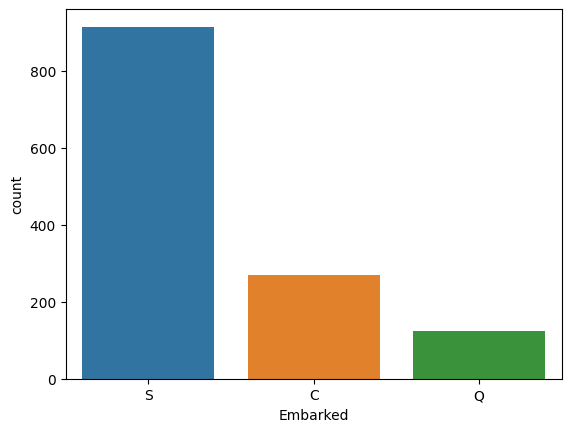

In [79]:
sns.countplot(x='Embarked', data=titanic_df)

In [80]:
# Embarked의 NA 값은 S로 채우기
# ...

In [14]:
titanic_df["Embarked"] = titanic_df["Embarked"].fillna(value="S")
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1046 non-null   float64
 1   Cabin        295 non-null    object 
 2   Embarked     1309 non-null   object 
 3   Fare         1308 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   object 
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Ticket       1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


### Title 정리

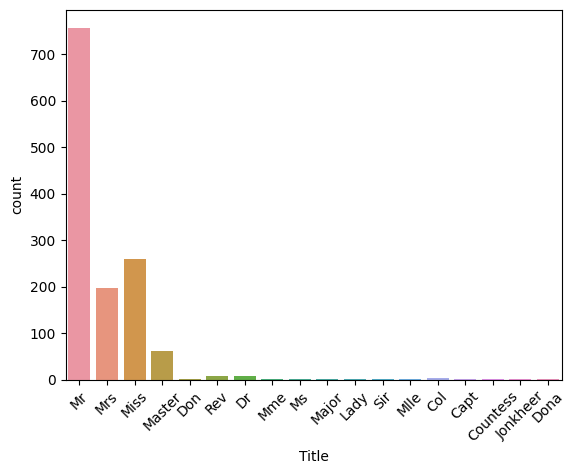

In [24]:
import re
titanic_df['Title'] = titanic_df.Name.apply(lambda x: re.search('([A-Z][a-z]+)\.', x).group(1))
sns.countplot(x='Title', data=titanic_df)
plt.xticks(rotation=45);

In [17]:
titanic_df['Title']

0           Mr
1          Mrs
2         Miss
3          Mrs
4           Mr
         ...  
1304        Mr
1305      Dona
1306        Mr
1307        Mr
1308    Master
Name: Title, Length: 1309, dtype: object

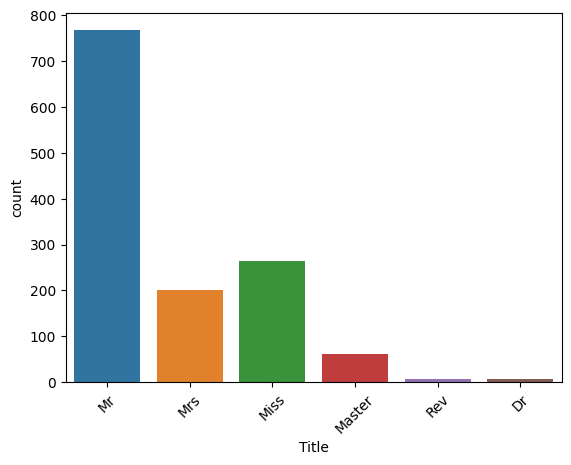

In [25]:
titanic_df['Title'] = titanic_df['Title'].replace({'Mlle': 'Miss', 
                                                   'Major': 'Mr', 
                                                   'Col': 'Mr', 
                                                   'Sir': 'Mr', 
                                                   'Don': 'Mr', 
                                                   'Mme': 'Miss', 
                                                   'Jonkheer': 'Mr', 
                                                   'Lady': 'Mrs', 
                                                   'Capt': 'Mr', 
                                                   'Countess': 'Mrs', 
                                                   'Ms': 'Miss', 
                                                   'Dona': 'Mrs'})
sns.countplot(x='Title', data=titanic_df);
plt.xticks(rotation=45);

### Age 정리

In [26]:
titles = ['Dr', 'Master', 'Miss', 'Mr', 'Mrs', 'Rev']
for title in titles:
    age_to_impute = titanic_df.groupby('Title')['Age'].median()[titles.index(title)]
    titanic_df.loc[(titanic_df['Age'].isnull()) & (titanic_df['Title'] == title), 'Age'] = age_to_impute

### SibSp, Parch 정리

In [27]:
titanic_df['Familial'] = (titanic_df['SibSp'] + titanic_df['Parch']) > 0
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 14 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1309 non-null   float64
 1   Cabin        295 non-null    object 
 2   Embarked     1309 non-null   object 
 3   Fare         1308 non-null   float64
 4   Name         1309 non-null   object 
 5   Parch        1309 non-null   int64  
 6   PassengerId  1309 non-null   int64  
 7   Pclass       1309 non-null   int64  
 8   Sex          1309 non-null   object 
 9   SibSp        1309 non-null   int64  
 10  Survived     891 non-null    float64
 11  Ticket       1309 non-null   object 
 12  Title        1309 non-null   object 
 13  Familial     1309 non-null   bool   
dtypes: bool(1), float64(3), int64(4), object(6)
memory usage: 134.3+ KB


In [66]:
medianFare = titanic_df[titanic_df['Pclass'] == 3]['Fare'].median()
titanic_df['Fare'] = titanic_df['Fare'].fillna(value = medianFare)

### Categorizing

In [65]:
# Age (17/80) 상한 / 하한
print(min(titanic_df["Age"]))
print(max(titanic_df["Age"]))

custom_bucket_array = np.linspace(0,80,17) # 15개 구간으로 나눔
# titanic_df["Age"]
titanic_df["CatAge"] = pd.cut(titanic_df["Age"], custom_bucket_array)
labels, y = pd.factorize(titanic_df["CatAge"])
titanic_df["CatAge"] = labels
# custom_bucket_array
# titanic_df["CatAge"]
# print(y)
# labels
print(titanic_df["Age"])
print(labels)

0.17
80.0
0       22.0
1       38.0
2       26.0
3       35.0
4       35.0
        ... 
1304    30.0
1305    39.0
1306    38.5
1307    30.0
1308     4.0
Name: Age, Length: 1309, dtype: float64
[0 1 2 ... 1 2 5]


In [62]:
# Fare
print(min(titanic_df["Fare"]))
print(max(titanic_df["Fare"]))

custom_bucket_array = np.linspace(0,520,53)
titanic_df["CatFare"] = pd.cut(titanic_df["Fare"], custom_bucket_array)
labels, _ = pd.factorize(titanic_df["CatFare"])
titanic_df["CatFare"] = labels
labels


0.0
512.3292


array([0, 1, 0, ..., 0, 0, 3], dtype=int64)

In [67]:
# 성별 및 기타...
titanic_df["SexBool"] = titanic_df["Sex"].map({"male" : 0 , "female" : 1})
titanic_df["Embarked"] = titanic_df["Embarked"].map({"S" : 0 ,"C" : 1, "Q" : 2 })
titanic_df["TitleInt"] = titanic_df["Title"].map({'Mr' : 0 , 'Mrs': 1,'Miss':2,
                                                   'Master':3, 'Rev' :4,'Dr':5})

## 기존 데이터로 되돌리기

In [68]:
# Get back the features engineered train_df & test_df
train_len = len(train_df)
train_df = titanic_df.loc[titanic_df['PassengerId'] <= train_len]
test_df = titanic_df.loc[titanic_df['PassengerId'] > train_len].iloc[:, titanic_df.columns != 'Survived']
(len(train_df), len(test_df))

(891, 418)

## 모델 학습

In [69]:
# X, y
Columns = ['SexBool', 'Pclass', 'Fare', 'CatAge', 'Familial', 'EmbarkedInt', 'TitleInt']
Label = 'Survived'
X_train = train_df.loc[:, train_df.columns != 'Survived']
y_train = train_df['Survived']

In [84]:
model = XGBClassifier()

In [85]:
both_scoring = {'AUC': 'roc_auc', 'Accuracy': make_scorer(accuracy_score), 'Loss':'neg_log_loss'}
params = {'n_estimators': [100, 200, 500, 1000, 1500],
          'learning_rate': [0.05, 0.1, 0.2],
          #'max_depth':[3, 4, 5]
          }

In [91]:
clf = GridSearchCV(model, params, cv=5, scoring=both_scoring, refit='AUC', return_train_score=True)
clf.fit(X_train[Columns], y_train)

KeyError: "['EmbarkedInt'] not in index"

In [87]:
print((clf.best_score_, clf.best_params_))
print("="*30)

print("Grid scores on training data:")
means = clf.cv_results_['mean_test_AUC']
stds = clf.cv_results_['std_test_AUC']
log_losses = clf.cv_results_['std_test_Loss']

for mean, std, log_loss, params in zip(means, stds, log_losses, clf.cv_results_['params']):
    print(f"AUC Score: {mean} (+/-{std*2}); Log Loss: {log_loss} for {params}")

AttributeError: 'GridSearchCV' object has no attribute 'best_score_'

In [88]:
results = clf.cv_results_

plt.figure(figsize=(13, 13))
plt.title("GridSearchCV evaluating using multiple scorers simultaneously", fontsize=16)

plt.xlabel("n_estimators: no of boosted trees")
plt.ylabel("AUC Score")

ax = plt.gca()
ax.set_xlim(80, 1020)
ax.set_ylim(0.7, 1)

X_axis = np.array(results['param_n_estimators'].data, dtype=float)

for scorer, color in zip(sorted(both_scoring), ['g', 'k']):
    for sample, style in (('train', '--'), ('test', '-')):
        sample_score_mean = results['mean_%s_%s' % (sample, scorer)]
        sample_score_std = results['std_%s_%s' % (sample, scorer)]
        ax.fill_between(X_axis, sample_score_mean - sample_score_std,
                        sample_score_mean + sample_score_std,
                        alpha=0.1 if sample == 'test' else 0, color=color)
        ax.plot(X_axis, sample_score_mean, style, color=color,
                alpha=1 if sample == 'test' else 0.7,
                label="%s (%s)" % (scorer, sample))

    best_index = np.nonzero(results['rank_test_%s' % scorer] == 1)[0][0]
    best_score = results['mean_test_%s' % scorer][best_index]

    # Plot a dotted vertical line at the best score for that scorer marked by x
    ax.plot([X_axis[best_index], ] * 2, [0, best_score],
            linestyle='-.', color=color, marker='x', markeredgewidth=3, ms=8)

    # Annotate the best score for that scorer
    ax.annotate("%0.2f" % best_score,
                (X_axis[best_index], best_score + 0.005))

plt.legend(loc="best")
plt.grid('off')
plt.show()

AttributeError: 'GridSearchCV' object has no attribute 'cv_results_'

In [89]:
# 예측
predictions = clf.predict(test_df[Columns]).astype(int)
submission = pd.DataFrame({'PassengerId':test_df['PassengerId'], 'Survived':predictions})

KeyError: "['SexBool', 'CatAge', 'Familial', 'EmbarkedInt', 'TitleInt'] not in index"

In [90]:
# Submit
from datetime import datetime
filename = datetime.today().strftime('%Y%m%d') + '_submit.csv'
submission.to_csv("../data/"+filename,index=False)

NameError: name 'submission' is not defined